## Bayesian network Impact factor Based on Analysis of Shifts (BIBAS) 


### Imports

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as patches
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import random

### A Small Demo BN:

#### The output is the validity of the Bayesian network (True = Valid)

In [83]:
# Defining a simple example Bayesian Network
bn = DiscreteBayesianNetwork([('A', 'C'), ('B', 'C'), ('C', 'D')])

cpd_A = TabularCPD(variable='A', variable_card=2, values=[[0.7], [0.3]])
cpd_B = TabularCPD(variable='B', variable_card=2, values=[[0.6], [0.4]])
cpd_C = TabularCPD(variable='C', variable_card=2,
                   values=[[0.9, 0.4, 0.5, 0.1],
                           [0.1, 0.6, 0.5, 0.9]],
                   evidence=['A', 'B'],
                   evidence_card=[2, 2])
cpd_D = TabularCPD(variable='D', variable_card=2,
                   values=[[0.8, 0.3],
                           [0.2, 0.7]],
                   evidence=['C'],
                   evidence_card=[2])

bn.add_cpds(cpd_A, cpd_B, cpd_C, cpd_D)
bn.check_model()

True

#### Let's define a simple function for plotting a network's strucure

In [86]:
def draw_bn_structure(bn):
    G = nx.DiGraph(bn.edges())
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', arrows=True, font_size=12)
    plt.title("Bayesian Network Structure")
    plt.show()

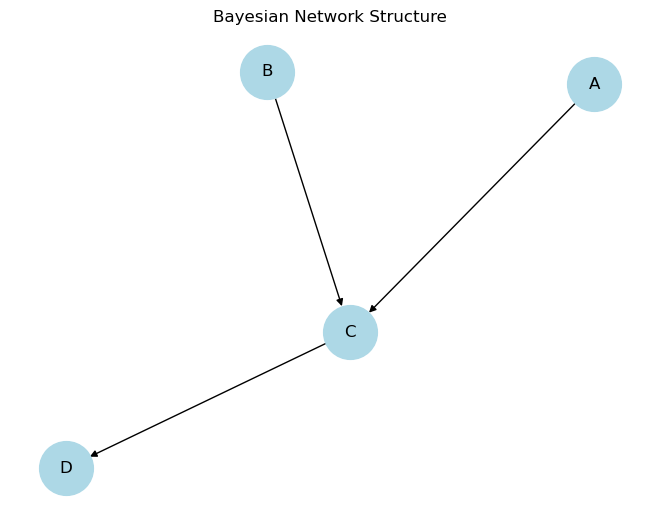

In [88]:
draw_bn_structure(bn)

#### And a function to calculate BIBAS factors between two nodes in the BN

In [94]:
def compute_bibas_pairwise(model, source, target):
    infer = VariableElimination(model)
    try:
        p1 = infer.query(variables=[target], evidence={source: 0}).values[1]
        p2 = infer.query(variables=[target], evidence={source: 1}).values[1]
    except:
        return np.nan
    return abs(p1 - p2) * 100

#### Calculation for each pair in each direction

In [97]:
ordered = sorted(bn.nodes())
bibas_matrix = pd.DataFrame(index=ordered, columns=ordered)

for source in ordered:
    for target in ordered:
        if source == target:
            bibas_matrix.loc[source, target] = np.nan  # leave diagonal empty
        else:
            bibas_matrix.loc[source, target] = compute_bibas_pairwise(bn, source, target)

bibas_matrix = bibas_matrix.astype(float)

#### And plotting the whole thing

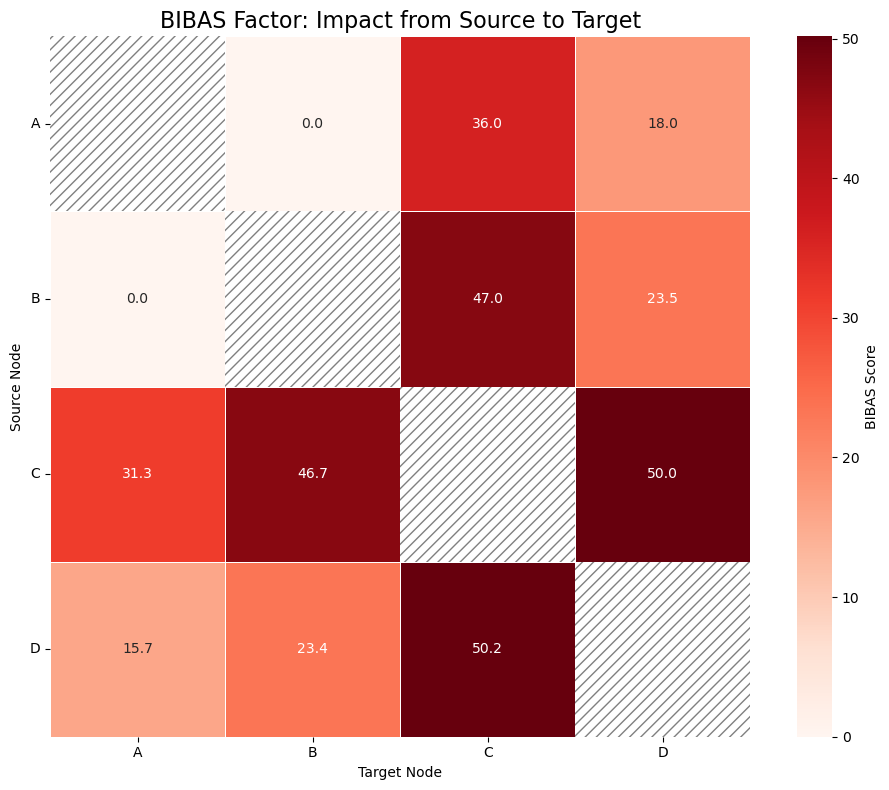

In [100]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bibas_matrix,
    annot=True,
    fmt=".1f",
    cmap='Reds',
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "BIBAS Score"},
    mask=np.eye(len(bibas_matrix), dtype=bool)
)

# Add diagonal hatching
for i in range(len(bibas_matrix)):
    rect = patches.Rectangle((i, i), 1, 1, hatch='///',
                             fill=False, edgecolor='gray', linewidth=0)
    ax.add_patch(rect)

plt.title("BIBAS Factor: Impact from Source to Target", fontsize=16)
plt.xlabel("Target Node")
plt.ylabel("Source Node")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Notice how the factor is asymetric, as information can flow in both directions of an edge, but in a different manner.
#### We can also see how A and B have 0 flow between them. The V shape connection with a mediator (C) unknown value results d-seperation.

## Now lets do it with a bigger example BN

In [108]:
# Create a random DAG with 10 nodes
random.seed(33)

nodes = [chr(i) for i in range(65, 75)]  # A–J
edges = []
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        if random.random() < 0.25:
            edges.append((nodes[i], nodes[j]))
            
bn = DiscreteBayesianNetwork(edges)

# 2. Add dummy binary CPDs
for node in bn_large.nodes():
    parents = bn_large.get_parents(node)
    num_parents = len(parents)
    card = 2
    num_rows = card
    num_cols = 2 ** num_parents if num_parents else 1
    values = np.random.dirichlet(np.ones(num_rows), size=num_cols).T
    cpd = TabularCPD(variable=node, variable_card=card, values=values,
                     evidence=parents if parents else None,
                     evidence_card=[2]*num_parents if num_parents else None)
    bn.add_cpds(cpd)

bn.check_model()

True

In [110]:
ordered = sorted(bn.nodes())
bibas_matrix = pd.DataFrame(index=ordered, columns=ordered)

for source in ordered:
    for target in ordered:
        if source == target:
            bibas_matrix.loc[source, target] = np.nan  # leave diagonal empty
        else:
            bibas_matrix.loc[source, target] = compute_bibas_pairwise(bn, source, target)

bibas_matrix = bibas_matrix.astype(float)

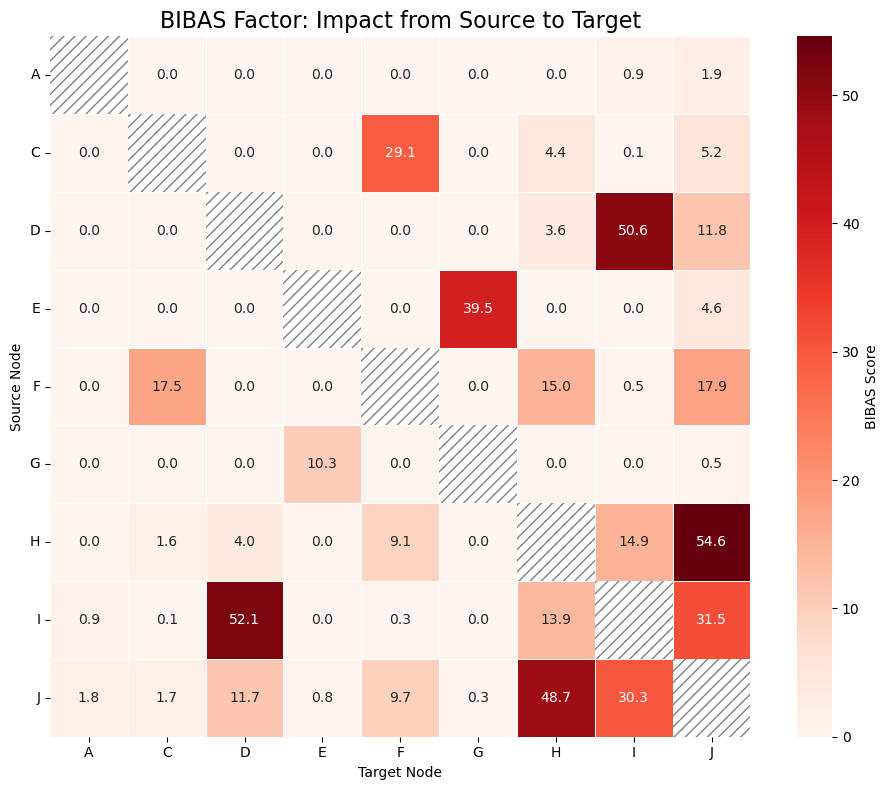

In [124]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    bibas_matrix,
    annot=True,
    fmt=".1f",
    cmap='Reds',
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": "BIBAS Score"},
    mask=np.eye(len(bibas_matrix), dtype=bool)
)

# Add diagonal hatching
for i in range(len(bibas_matrix)):
    rect = patches.Rectangle((i, i), 1, 1, hatch='///',
                             fill=False, edgecolor='gray', linewidth=0)
    ax.add_patch(rect)

plt.title("BIBAS Factor: Impact from Source to Target", fontsize=16)
plt.xlabel("Target Node")
plt.ylabel("Source Node")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()